In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from matplotlib import pyplot as plt
from sklearn import metrics

## Implementacja neuronu

In [4]:
from abc import ABC, abstractmethod
import logging

class Neuron(ABC):
    def __init__(self, weights: list) -> None:
        self.weights = weights
        self.output = 0
        self.deltas = []
        self.delta = 0
        self.error = 0
        self.input = 0
        self.momentum = [0 for i in range(len(weights))]
        self.grads_squared = [0 for i in range(len(weights))]
        self.inputs = []
        if len(weights) < 2:
            logging.warning("Less than 2 weights. Are you sure?")
    
    def __repr__(self) -> str:
        return "%s(weights: %s, output: %s, delta: %s, error: %s)" % (self.name(), str(self.weights), str(self.output), str(self.delta), str(self.error))
            
    @abstractmethod
    def evaluate(self, input: list) -> float:
        pass
    
    @abstractmethod
    def name(self) -> str:
        pass
    
    @abstractmethod
    def derivative(self, output: float) -> float:
        pass
    
    def add_one(l: list) -> list:
        tmp = [1]
        tmp.extend(l)
        return tmp
    
    def dot(a: list, b: list) -> float:
        tmp = min(len(a), len(b))
        return np.dot(a[:tmp], b[:tmp])

    
# pierwsza waga to waga biasu
class LinearNeuron(Neuron):
    def evaluate(self, input: list) -> float:
        self.inputs = Neuron.add_one(input)
        self.output = Neuron.dot(self.weights, self.inputs)
        self.input = self.output
        return self.output
    
    def name(self) -> str:
        return "LinearNeuron"
    
    def derivative(self, output: float) -> float:
        return 1.0
        

class SigmoidNeuron(Neuron):
    def evaluate(self, input: list) -> float:
        self.inputs = Neuron.add_one(input)
        x = Neuron.dot(self.weights, self.inputs)
        self.input = x
#         if abs(x) > 10:
#             print("weights: %s, input: %s" % (self.weights, self.inputs))
        self.output = math.e ** x / (1 + math.e ** x)
        return self.output
    
    def name(self) -> str:
        return "SigmoidNeuron"
    
    def derivative(self, output: float) -> float:
        return output * (1.0 - output)

# tests

assert Neuron.dot([2,3], [5]) == 10
assert Neuron.dot([2,3], [4,5,6]) == 23

linearneuron = LinearNeuron([1,2,3])
assert linearneuron.evaluate([1,2,3]) == 9
assert linearneuron.evaluate([2,3]) == 14

sigmoidneuron = SigmoidNeuron([1, 2])
assert sigmoidneuron.evaluate([1]) == math.e ** 3 / (1 + math.e ** 3)
print(linearneuron)
print(sigmoidneuron)

LinearNeuron(weights: [1, 2, 3], output: 14, delta: 0, error: 0)
SigmoidNeuron(weights: [1, 2], output: 0.9525741268224333, delta: 0, error: 0)


## Implementacja warstwy

In [3]:
class Layer(ABC):
    def __init__(self) -> None:
        self.neurons = []
    
    @abstractmethod
    def __init__(self, num: int, weights: list) -> None:
        pass
        
    def addNeuron(self, neuron: Neuron) -> None:
        self.neurons.append(neuron)
        
    def evaluate(self, input: list) -> list:
        return [neuron.evaluate(input) for neuron in self.neurons]
    
    def __repr__(self) -> str:
        return "Layer(" + str(self.neurons) + ")"
    

class LinearLayer(Layer):
    def __init__(self, num: int, weights: list) -> None:
        assert len(weights) == num, "Invalid matrix dimension"
        self.neurons = [LinearNeuron(w) for w in weights]
    
class SigmoidLayer(Layer):
    def __init__(self, num: int, weights: list) -> None:
        assert len(weights) == num, "Invalid matrix dimension"
        self.neurons = [SigmoidNeuron(w) for w in weights]

# tests
layer1 = LinearLayer(1, [[1, 2]])
assert layer1.evaluate([5]) == [11]
layer1.addNeuron(LinearNeuron([2, 3]))
assert layer1.evaluate([5]) == [11, 17]

layer2 = LinearLayer(2, [[1,2], [2, 3]])
assert layer2.evaluate([5]) == [11, 17]
print(layer2)

Layer([LinearNeuron(weights: [1, 2], output: 11, delta: 0, error: 0), LinearNeuron(weights: [2, 3], output: 17, delta: 0, error: 0)])


## Implementacja sieci

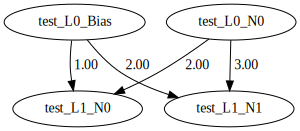

In [14]:
from graphviz import Digraph
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import copy

class Network:
    def __init__(self) -> None:
        self.layers = []
        self.size = []
        self.s = None
    
    def __repr__(self) -> str:
        return "Network(" + "\n\t".join([str(layer) for layer in self.layers]) + ")"
    
    def __init__(self, layer_types: list, size: list, weights=None, gen_type="0|1", norm=True) -> None:
        assert len(layer_types) == len(size) - 1, "Invalid matrix dimension"
        self.layers = []
        self.size = size
        self.norm = norm
        for i, layer_type in enumerate(layer_types):
            if layer_type == "sigmoid":
                self.addLayerBack(SigmoidLayer(size[i + 1], weights[i] if weights else Network.generate(gen_type, (size[i + 1], size[i] + 1))))
            elif layer_type == "linear":
                self.addLayerBack(LinearLayer(size[i + 1], weights[i] if weights else Network.generate(gen_type, (size[i + 1], size[i] + 1))))
            else:
                logging.error("Invalid layer type")
    
    @staticmethod
    def batch_partition(list_in, n):
        l = copy.deepcopy(list_in)
        random.shuffle(l)
        return [l[(i * n):(i * n + n)] for i in range(int((len(l) + n - 1) / n))]
        
    def generate(gen_type: str, n: tuple) -> np.array:
        if gen_type == "0|1":
            return np.random.uniform(0, 1, n)
        elif gen_type == "-1|1":
            return np.random.uniform(-1, 1, n)
        elif gen_type == "norm":
            return np.random.normal(0, 1, n)
        elif gen_type == "zero":
            return np.zeros(n)
        
    
    def addLayerBack(self, layer: Layer) -> None:
        self.layers.append(layer)
    
    def forward(self, x: list) -> list:
        input = x
        for layer in self.layers:
            out = []
            for val in input:
                tmp = layer.evaluate(val)
                out.append(tmp)
            input = out
        return input
    
    def predict(self, x):
        if self.norm:
            return self.s.inverse_transform(self.forward(x))
        return self.forward(x)
    
    def draw(self, prefix='', graph=None) -> None:
        g = Digraph(format='svg', name="neural network")
        if graph is not None:
            g = graph
        for idx, layer in enumerate(self.layers):
            current_id = idx + 1
            # create bias neuron
            bias_name = '%s_L%s_Bias' % (prefix, idx)
            g.node(bias_name)
            for n_i, neuron in enumerate(layer.neurons):
                # create dot for neuron
                neuron_name = '%s_L%s_N%s' % (prefix, current_id, n_i)
                g.node(neuron_name)
                # create dots and edges for parents
                for w_i, weight in enumerate(neuron.weights):
                    if w_i == 0:
                        g.edge(bias_name, neuron_name, label=format(weight, '.2f'))
                    else:
                        p_name = '%s_L%s_N%s' % (prefix, idx, w_i - 1)
                        g.node(p_name)
                        g.edge(p_name, neuron_name, label=format(weight, '.2f'))
        return g
            
    def backward_propagate_error(self, expected, l_rate):
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            
            if layer == self.layers[-1]:
                for j, neuron in enumerate(layer.neurons):
                    neuron.error = (expected[j] - neuron.output)
                    neuron.delta += neuron.error * neuron.derivative(neuron.output)
                    neuron.current_delta = neuron.error * neuron.derivative(neuron.output)
                    neuron.current_error = (expected[j] - neuron.output)
                    
                    for k in range(len(neuron.weights)):
                        neuron.deltas[k] += neuron.current_delta * neuron.inputs[k]
            else:
                next_layer = self.layers[i + 1]
                for j, neuron in enumerate(layer.neurons):
                    neuron.current_error = 0
                    neuron.current_delta = 0
                    for k, next_neuron in enumerate(next_layer.neurons):
                        neuron.current_error += next_neuron.weights[j+1] * next_neuron.current_delta
                    neuron.current_delta = neuron.current_error * neuron.derivative(neuron.output)
                    for k in range(len(neuron.weights)):
                        neuron.deltas[k] += neuron.current_delta * neuron.inputs[k]
    
    def update_weights(self, l_rate, size, momentum=False, m_lambda=0.1, rmsprop=False, rms_beta=0.9):
        for layer in self.layers:
            for neuron in layer.neurons:
                for i in range(len(neuron.weights)):
                    if momentum:
                        neuron.momentum[i] = neuron.momentum[i] * m_lambda + neuron.deltas[i] / size
                        neuron.weights[i] += neuron.momentum[i] * l_rate
                    elif rmsprop:
                        neuron.grads_squared[i] = rms_beta * neuron.grads_squared[i] + (1.0 - rms_beta) * (neuron.deltas[i] / size) ** 2
                        neuron.weights[i] += l_rate * (neuron.deltas[i] / size) / math.sqrt(neuron.grads_squared[i])
                    else:
                        neuron.weights[i] += neuron.deltas[i] * l_rate / size
    
    def clean_params(self):
        for idx, layer in enumerate(self.layers):
            for neuron in layer.neurons:
                neuron.output = 0
                neuron.delta = 0
                neuron.deltas = [0 for i in range(len(neuron.weights))]
    
    def train_network(self, train_data: list, train_y: list, l_rate=1e-3, n_epoch=5, batch_size=None,
                     momentum=False, m_lambda=0.1, rmsprop=False, rms_beta=0.9) -> None:
        errors = []
        y_std = train_y
        if self.norm:
            self.s = StandardScaler()
            y_std = self.s.fit_transform(train_y)
        joined = [(train_data[i], y_std[i]) for i in range(len(train_y))]
        a = self.draw("null")
        for epoch in range(n_epoch):
            sum_error = 0
            batches = Network.batch_partition(joined, batch_size) if batch_size else [joined]
            for batch_idx, batch in enumerate(batches):
                self.clean_params()
                for i, row in enumerate(batch):
                    x, expected = row
                    outputs = self.forward([row])
                    sum_error += sum([(expected[i]-outputs[0][i])**2 for i in range(len(expected))])
                    self.backward_propagate_error(expected, l_rate)
                self.update_weights(l_rate, len(batch), momentum, m_lambda, rmsprop, rms_beta)
            if epoch % 100 == 99:
                a = self.draw(str(epoch), a)
            errors.append(sum_error)
#             print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))
        return (a, errors)
        

# tests
network = Network(["linear"], [1, 1], [[[1,2,3]]])
assert network.forward([[2,3]]) == [[14]]

network2 = Network(["linear"], [1, 2], [
        [[1,2], [2, 3]]
])
assert network2.forward([[5]]) == [[11, 17]]
network2.draw("test")
# https://gluon.mxnet.io/chapter06_optimization/rmsprop-scratch.html

Jupyter ma czasem problem z wyświetlaniem grafów. Gdyby nie działało, można wejść na githuba z moim kodem, tam się wyświetlają poprawnie: https://github.com/niladrem/mioad/blob/master/lab02.ipynb

# Zbiór square-large

In [6]:
train_df = pd.read_csv('./mio1/regression/square-large-training.csv', index_col=0)
test_df = pd.read_csv('./mio1/regression/square-large-test.csv', index_col=0)

CPU times: user 4.42 s, sys: 0 ns, total: 4.42 s
Wall time: 4.46 s


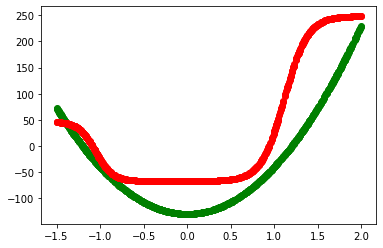

In [45]:
%%time
np.random.seed(2137) # seed ustawiony na sztywno, by zawsze dostawać te same wyniki
rmsprop_mlp = Network(["sigmoid", "linear"], [1,4,1], gen_type="0|1", norm=True)
_, rmsprop_err = rmsprop_mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=0.5, rmsprop=True, batch_size=32)

y_pred = rmsprop_mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

CPU times: user 3.97 s, sys: 15.6 ms, total: 3.98 s
Wall time: 3.98 s


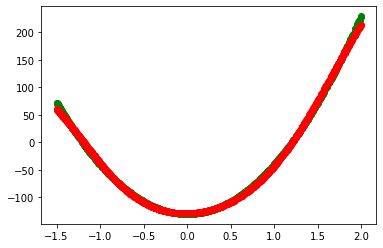

In [40]:
%%time
np.random.seed(2137) # seed ustawiony na sztywno, by zawsze dostawać te same wyniki
momentum_mlp = Network(["sigmoid", "linear"], [1,4,1], gen_type="0|1", norm=True)
_, momentum_err = momentum_mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=0.5, momentum=True, batch_size=32)

y_pred = momentum_mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

CPU times: user 3.98 s, sys: 0 ns, total: 3.98 s
Wall time: 3.98 s


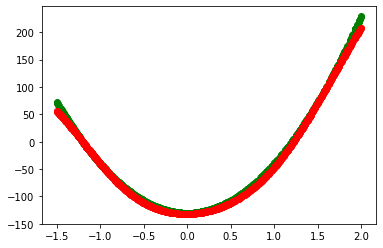

In [41]:
%%time
np.random.seed(2137) # seed ustawiony na sztywno, by zawsze dostawać te same wyniki
normal_mlp = Network(["sigmoid", "linear"], [1,4,1], gen_type="0|1", norm=True)
_, normal_err = normal_mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=0.5, batch_size=32)

y_pred = normal_mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

(0.0, 2000.0)

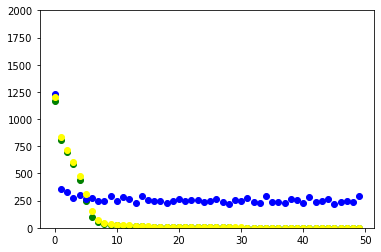

In [42]:
plt.scatter(range(len(momentum_err)), momentum_err, color='green')
plt.scatter(range(len(rmsprop_err)), rmsprop_err, color='blue')
plt.scatter(range(len(normal_err)), normal_err, color='yellow')
plt.ylim(0, 2000)

In [27]:
def get_score(network, df):
    y_pred = network.predict(np.expand_dims(df['x'], 1))
    y_pred = np.squeeze(y_pred)
    return metrics.mean_absolute_error(df['y'], y_pred)

### Wynik na zbiorze testowym
##### normalna

In [29]:
get_score(normal_mlp, test_df)

81.72717675943728

##### RMSProp

In [30]:
get_score(rmsprop_mlp, test_df)

55.95607111510421

##### moment

In [31]:
get_score(momentum_mlp, test_df)

79.92144889361849

CPU times: user 2.22 s, sys: 4 ms, total: 2.23 s
Wall time: 2.23 s


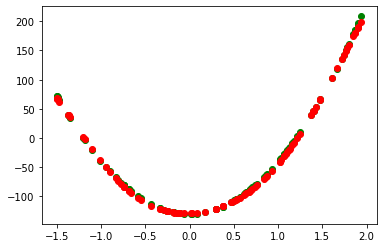

In [19]:
%%time
np.random.seed(2137)
mlp = Network(["sigmoid", "linear"], [1,4,1], gen_type="-1|1") # generowanie z rozkładu U(-1,1)
g = mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=300, l_rate=0.5, batch_size=8)

y_pred = mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

##### Wynik na zbiorze treningowym

In [20]:
metrics.mean_absolute_error(train_df['y'], y_pred)

2.2136448574680543

##### Wynik na zbiorze testowym

In [21]:
y_pred = mlp.predict(np.expand_dims(test_df['x'], 1))
y_pred = np.squeeze(y_pred)
metrics.mean_absolute_error(test_df['y'], y_pred)

1.8887115584585916

# Zbiór steps-small

In [22]:
train_df = pd.read_csv('./mio1/regression/steps-small-training.csv', index_col=0)
test_df = pd.read_csv('./mio1/regression/steps-small-test.csv', index_col=0)

CPU times: user 2.12 s, sys: 24 ms, total: 2.14 s
Wall time: 2.08 s


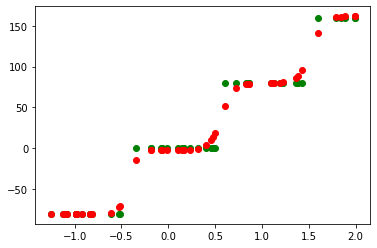

In [28]:
%%time
np.random.seed(2137)
mlp = Network(["sigmoid", "linear"], [1,10,1], norm=False) # wyłączenie domyślnej normalizacji outputu
mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=300, l_rate=1e-1)

y_pred = mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

##### Wynik na zbiorze treningowym

In [29]:
metrics.mean_absolute_error(train_df['y'], y_pred)

4.035531738656447

##### Wynik na zbiorze testowym

In [30]:
y_pred = mlp.forward(np.expand_dims(test_df['x'], 1))
y_pred = np.squeeze(y_pred)
metrics.mean_absolute_error(test_df['y'], y_pred)

5.1547183807170605

CPU times: user 2.27 s, sys: 0 ns, total: 2.27 s
Wall time: 2.27 s


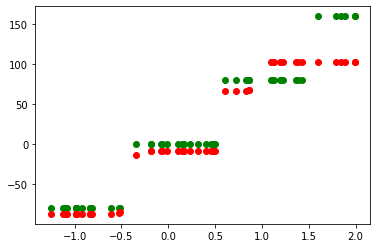

In [32]:
%%time
np.random.seed(2137)
mlp = Network(["sigmoid", "linear"], [1,10,1], norm=False)
mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=300, l_rate=1e-1, batch_size=8)

y_pred = mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

##### Wynik na zbiorze treningowym

In [33]:
metrics.mean_absolute_error(train_df['y'], y_pred)

16.733270581690363

##### Wynik na zbiorze testowym

In [34]:
y_pred = mlp.forward(np.expand_dims(test_df['x'], 1))
y_pred = np.squeeze(y_pred)
metrics.mean_absolute_error(test_df['y'], y_pred)

21.718396180150926

# Zbiór multimodal-large

In [35]:
train_df = pd.read_csv('./mio1/regression/multimodal-large-training.csv', index_col=0)
test_df = pd.read_csv('./mio1/regression/multimodal-large-test.csv', index_col=0)

CPU times: user 43.4 s, sys: 284 ms, total: 43.7 s
Wall time: 43.4 s


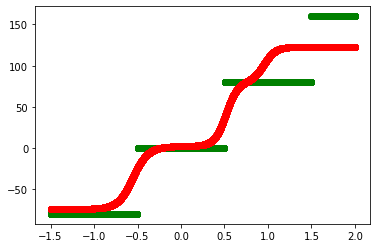

In [37]:
%%time
np.random.seed(1111)
mlp = Network(["sigmoid", "linear"], [1,5,1], gen_type="norm", norm=False) #generowanie z rozkładu normalnego N(0,1)
mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=1e-1)

y_pred = mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

##### Wynik na zbiorze treningowym

In [38]:
metrics.mean_absolute_error(train_df['y'], y_pred)

18.385689665294905

##### Wynik na zbiorze testowym

In [39]:
y_pred = mlp.forward(np.expand_dims(test_df['x'], 1))
y_pred = np.squeeze(y_pred)
metrics.mean_absolute_error(test_df['y'], y_pred)

18.8883323656715

CPU times: user 46.9 s, sys: 220 ms, total: 47.1 s
Wall time: 46.9 s


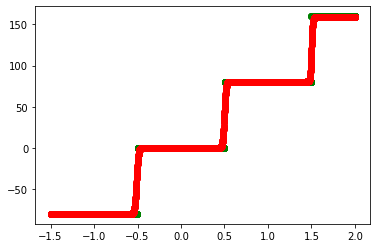

In [40]:
%%time
np.random.seed(2137)
mlp = Network(["sigmoid", "linear"], [1,5,1], gen_type="norm", norm=False)
mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=1e-1, batch_size=32)

y_pred = mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

##### Wynik na zbiorze treningowym

In [41]:
metrics.mean_absolute_error(train_df['y'], y_pred)

1.2851275681512369

##### Wynik na zbiorze testowym

In [42]:
y_pred = mlp.forward(np.expand_dims(test_df['x'], 1))
y_pred = np.squeeze(y_pred)
metrics.mean_absolute_error(test_df['y'], y_pred)

1.725113163027896

# Wnioski
Zdecydowanie widać, że metoda z batchem jest trochę wolniejsza niż poprawianie wag dopiero po całym zbiorze (oczywiście czas zależy od wielkości batcha - najwolniejsze jest aktualizowanie wag po każdej próbce), ale daje lepsze dopasowanie. Generalnie sieć uczy się całkiem dobrze. Im więcej jest danych, tym lepiej to wychodzi. Wyniki na zbiorze testowym są porównywalne do treningowego.